### Physics Informed Neural Operator (PINO): Solving a ODE for different right hand sides
In this notebook, we present an introduction to the PINO [(paper)](https://arxiv.org/abs/2111.03794) concept in TorchPhysics. 
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } (0, 1) \\
    u(0) &= 0
\end{align*}
for different functions $f$. Since this a physics informed approach no data is requiered.

In [2]:
import torch 
import torchphysics as tp
import pytorch_lightning as pl

Define the spaces that appear:

In [3]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

input_fn_space = tp.spaces.FunctionSpace(T, F)

Create the FNO we want to use to learn the solution:

In [4]:
hidden_channels = 16

model = tp.models.FNO(F, U, 
                      fourier_layers=5, 
                      hidden_channels=hidden_channels, 
                      fourier_modes=8, 
                      skip_connections=True, 
                      channel_up_sample_network=torch.nn.Sequential(
                          torch.nn.Linear(F.dim, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, hidden_channels)
                      ),
                      channel_down_sample_network=torch.nn.Sequential(
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, U.dim)
                      ),
                      space_resolution=100)

We need to implement the differential equation via loss terms. Since the FNO acts by default on a discrete grid, we need to define this
grid here:

In [5]:
N_time = 100 # number of grid points
time_grid = torch.linspace(0, 1, N_time).reshape(-1, 1)
step_size = time_grid[1, 0] - time_grid[0, 0]
time_grid_points = tp.spaces.Points(time_grid.unsqueeze(0), T)

Next, we need to choose what functions we want to consider for the right-hand side. Here, we use a fourier basis given by the
class **HarmonicFunctionSet1D**.

In [6]:
harmonic_fn_set = tp.domains.HarmonicFunctionSet1D(
    input_fn_space, 
    function_set_size=50000, 
    period=1.0, 
    max_frequence=4
)

# The functions are only needed at the discrete grid points
# so we can discretize the function set:
discrete_harmonic_fn_set = harmonic_fn_set.discretize(time_grid_points)

# Create a sampler for the function set, that will pass 10000 functions
# in each trainig step to the model and after 100 steps will create new functions from
# the function set.
fn_sampler = tp.samplers.FunctionSamplerRandomUniform(10000, discrete_harmonic_fn_set, 100)

To implement the ODE we have to compute the time derivative $\partial_t$ of the model output. Since FNOs are working on the
discrete grid, we can not directly use autograd to compute the derivative. Instead we utilize a finite difference scheme to approximate the derivative on the grid.
For this different methods are implemented in the **utils** section. This is the reason we needed to fix a grid above, such that we now know the grid size.

In [7]:
def ode_residual(u, f):
    u_t = tp.utils.discrete_grad_on_grid(u, grid_size=step_size)
    return u_t - f

ode_condition = tp.conditions.PIOperatorCondition(module=model, 
                                                  input_function_sampler=fn_sampler, 
                                                  residual_fn=ode_residual, 
                                                  weight=0.1)

Also we need to enforce the initial condition:

In [8]:
def initial_residual(u):
    return u[:, 0]

initial_condition = tp.conditions.PIOperatorCondition(module=model, 
                                                      input_function_sampler=fn_sampler, 
                                                      residual_fn=initial_residual, 
                                                      weight=100.0)

Now start training:

In [ ]:
lr_list = [0.001, 0.0001, 0.00005]
step_list = [2000, 2500, 2500]

for i in range(len(lr_list)):
    optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=lr_list[i])
    solver = tp.solver.Solver([ode_condition, initial_condition], optimizer_setting=optim)

    trainer = pl.Trainer(devices=1, accelerator="gpu",
                        num_sanity_val_steps=0,
                        benchmark=True,
                        max_steps=step_list[i], 
                        logger=False, 
                        enable_checkpointing=False)

    trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 4.1 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch

Epoch 0:   1%|          | 19/2000 [00:03<05:51,  5.64it/s, train/loss=38.20]

Finally check the learned model on unseen data:

In [ ]:
N_test = 1000
discrete_harmonic_fn_set.create_functions()
test_fns = discrete_harmonic_fn_set.get_function(torch.arange(N_test))

model_out = model(test_fns).as_tensor

output_data_test = torch.zeros((N_test, N_time, 1))
test_fns = test_fns.as_tensor
for i in range(1, N_time):
    output_data_test[:, i, 0] = output_data_test[:, i-1, 0] + step_size * test_fns[:, i, 0]

print("Max error:", torch.max(torch.abs(output_data_test - model_out)).detach().item())
rel_error = 100.0 * torch.max(torch.abs(output_data_test - model_out))/torch.max(torch.abs(output_data_test))
print("Rel. error:", rel_error.detach().item(), "%")

Max error: 0.22796916961669922
Rel. error: 7.81789493560791 %


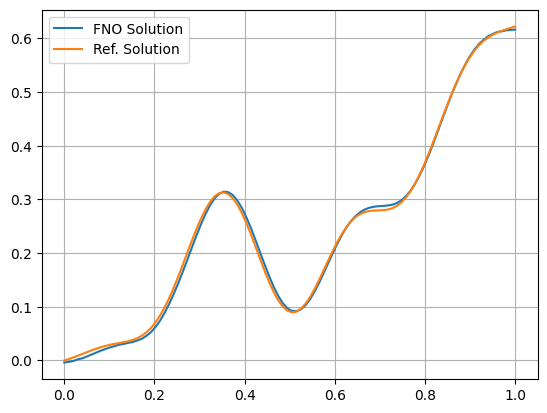

In [ ]:
import matplotlib.pyplot as plt

example_plot = 142
t = torch.linspace(0, 1, N_time)
plt.plot(time_grid[0], model_out[example_plot].detach().cpu())
plt.plot(time_grid[0], output_data_test[example_plot].detach().cpu())
plt.legend(["FNO Solution", "Ref. Solution"])
plt.grid()